In [3]:
import pandas as pd
import mysql.connector
from sqlalchemy import create_engine
import urllib.parse
from datetime import datetime
import pytz
import requests
import matplotlib.pyplot as plt
import numpy as np
import torch
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
import torch.nn.parallel
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import recall_score
import seaborn as sns
import xgboost as xgb
from sklearn.metrics import accuracy_score
from imblearn.over_sampling import SMOTE, SMOTENC
from imblearn.over_sampling import BorderlineSMOTE
from skorch import NeuralNetClassifier
from sklearn.model_selection import GridSearchCV
from google.colab import drive


# Table of Content
* [Data Preprocess](#Data-Preprocess)
* [Model Definition](#Model-Definition)
    * [Logistic Regression](#Logistic-Regression)
    * [Random Forest](#Random-Forest)
    * [XG Boost](#XG-Boost)
    * [Neural Network](#Neural-Network)
* [Customer Reach](#Customer-Reach)
* [Customer Conversion](#Customer-Conversion)
* [Customer Repurchase](#Customer-Repurchase)
* [Models Without SMOTE](#Models-Without-SMOTE)

# Data Preprocess

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device_ids = [0]

In [5]:
def preprocess_dataframe(df, numerical_cols):
    categorical_cols = list(set(df.columns) - set(numerical_cols))
    if len(df.columns) == 1:
        # Only one categorical column
        encoder = OneHotEncoder(sparse=False)
        encoded_data = encoder.fit_transform(df)
        tensor_data = torch.tensor(encoded_data, dtype=torch.float32)
    else:
        # One-hot encoding for categorical columns
        encoder = OneHotEncoder(sparse=False)
        encoded_data = encoder.fit_transform(df[categorical_cols])

        if len(df.columns) == len(categorical_cols):
            tensor_data = torch.tensor(encoded_data, dtype=torch.float32)
        else:
            # Normalizing numerical columns to the range of [-1, 1]
            numerical_cols = [col for col in df.columns if col not in categorical_cols]
            scaler = MinMaxScaler(feature_range=(-1, 1))
            normalized_data = scaler.fit_transform(df[numerical_cols])
            has_nan = np.isnan(normalized_data).any()
            if has_nan:
                print('has nan')

            # Concatenating encoded categorical columns and normalized numerical columns
            tensor_data = torch.tensor(
                np.concatenate([encoded_data, normalized_data], axis=1), dtype=torch.float32
            )

    return tensor_data

In [6]:
drive.mount('/content/drive')
customer_reach_final = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/eHello/customer_reach_final.csv')
customer_conversion_final = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/eHello/customer_conversion_final.csv')
customer_repurchase_final = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/eHello/customer_repurchase_final.csv')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
category_counts = customer_reach_final['trial_completed'].value_counts()
print(category_counts)

category_counts = customer_conversion_final['if_converted'].value_counts()
print(category_counts)

category_counts = customer_repurchase_final['if_repurchase'].value_counts()
print(category_counts)

0    98513
1    59577
Name: trial_completed, dtype: int64
0    50986
1     8591
Name: if_converted, dtype: int64
0    6796
1    2800
Name: if_repurchase, dtype: int64


# Model Definition

### Logistic Regression

In [12]:
import numpy as np
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import f1_score, classification_report
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTE


def k_fold_cv(X, y, k):
    l1_ratios = [0, 0.1, 0.3, 0.5, 0.7, 0.9, 1]

    # Initialize variables to store the best l1 ratio, its corresponding F1 score, and the best model
    best_l1_ratio = None
    best_f1_score = 0.0
    best_model = None

    # Split the data into train, validation, and test sets
    X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42)

    if isinstance(X_train, pd.DataFrame):
        X_train = X_train.values
        X_val = X_val.values
        X_test = X_test.values
    if isinstance(y_train, pd.DataFrame) or isinstance(y_train, pd.Series):
        y_train = y_train.values.ravel()
        y_val = y_val.values.ravel()
        y_test = y_test.values.ravel()

    # Perform k-fold cross-validation for each l1 ratio
    kf = KFold(n_splits=k, shuffle=True, random_state=42)
    for l1_ratio in l1_ratios:
        f1_scores = []

        # Perform k-fold cross-validation
        for train_index, val_index in kf.split(X_train_val):
            X_train_fold, X_val_fold = X_train_val.iloc[train_index], X_train_val.iloc[val_index]
            y_train_fold, y_val_fold = y_train_val.iloc[train_index], y_train_val.iloc[val_index]

            smote = SMOTE(sampling_strategy='auto', random_state=42)
            X_train_fold, y_train_fold = smote.fit_resample(X_train_fold, y_train_fold)

            # Create and train the model with the current l1 ratio
            model_elas = LogisticRegression(penalty='elasticnet', max_iter=1500, solver='saga', l1_ratio=l1_ratio)
            model_elas.fit(X_train_fold, y_train_fold)

            # Make predictions on the validation set
            y_pred_val = model_elas.predict(X_val_fold)

            # Calculate F1 score and store it
            f1 = f1_score(y_val_fold, y_pred_val)
            f1_scores.append(f1)

        # Calculate the average F1 score for the current l1 ratio
        average_f1_score = np.mean(f1_scores)

        # Check if the current l1 ratio has a higher F1 score than the previous best
        if average_f1_score > best_f1_score:
            best_f1_score = average_f1_score
            best_l1_ratio = l1_ratio
            best_model = model_elas

    # Train the best model on the combined train and validation sets
    X_train, y_train = smote.fit_resample(np.concatenate((X_train, X_val)), np.concatenate((y_train, y_val)))
    best_model.fit(X_train, y_train)

    # Evaluate the best model on the test set
    y_pred_test = best_model.predict(X_test)
    test_f1_score = f1_score(y_test, y_pred_test)

    # Print the best l1 ratio and its corresponding F1 score on the validation set
    print("Best l1 ratio:", best_l1_ratio)
    print("Best F1 score on validation set:", best_f1_score)

    # Print the F1 score of the best model on the test set
    print("F1 score on test set:", test_f1_score)
    print(classification_report(y_test, y_pred_test))

    return best_model



In [13]:
def plot_confusion_matrix(y_test, y_pred, title):
    print(classification_report(y_test, y_pred))
    # Generate confusion matrix
    cm = confusion_matrix(y_test, y_pred)

    total = np.sum(cm)
    cm_percent = cm / total * 100

    # Create a heatmap plot using seaborn
    sns.heatmap(cm_percent, annot=True, cmap="Blues", fmt=".2f", cbar=False)

    # Add labels, title, and axis ticks
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.title("Confusion Matrix (Percentage) of " + title)
    plt.xticks(ticks=[0.5, 1.5], labels=["Negative", "Positive"])
    plt.yticks(ticks=[0.5, 1.5], labels=["Negative", "Positive"])

    # Show the plot
    plt.show()

    accuracy = accuracy_score(y_test, y_pred)
    print("Accuracy:", accuracy)

    recall = recall_score(y_test, y_pred)
    print("Recall:", recall)

    print("confusion matrix:", cm)

In [27]:
def run_logistic_regression_with_penalty(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    smote = SMOTE(sampling_strategy='auto', random_state=42)
    X_train, y_train = smote.fit_resample(X_train, y_train)

    print('penalty: l2')
    model_l2 = LogisticRegression(penalty='l2', max_iter=500, solver='saga', n_jobs=32)
    model_l2.fit(X_train, y_train)
    y_pred_l2 = model_l2.predict(X_test)
    plot_confusion_matrix(y_test, y_pred_l2, 'l2 penalty')
    print('penalty: l2 done')

    print('penalty: l1')
    model_l1 = LogisticRegression(penalty='l1', max_iter=500, solver='saga', n_jobs=32)
    model_l1.fit(X_train, y_train)
    y_pred_l1 = model_l1.predict(X_test)
    plot_confusion_matrix(y_test, y_pred_l1, 'l1 penalty')
    print('penalty: l1 done')

    print('penalty: none')
    model_no_pen = LogisticRegression(penalty='none', max_iter=500, solver='saga', n_jobs=32)
    model_no_pen.fit(X_train, y_train)
    y_pred_no_pen = model_no_pen.predict(X_test)
    plot_confusion_matrix(y_test, y_pred_no_pen, 'no penalty')
    print('penalty: none done')

    return [model_l1, model_l2, model_no_pen]


### Random Forest

In [28]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

def run_random_forest(X, y, n_estimators):
    # Split the data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    smote = SMOTE(sampling_strategy='auto', random_state=42)
    X_train, y_train = smote.fit_resample(X_train, y_train)

    # Instantiate the Random Forest classifier
    model = RandomForestClassifier(n_estimators=n_estimators, random_state=42, n_jobs=32)
    # Train the model
    model.fit(X_train, y_train)
    # Make predictions on the test set
    y_pred = model.predict(X_test)
    plot_confusion_matrix(y_test, y_pred, '# of estimator = ' + str(n_estimators))


In [29]:
def k_fold_cv_random_forest(X, y, k):
    # Initialize variables to store the best hyperparameters and corresponding F1 score
    best_n_estimators = None
    best_max_depth = None
    best_f1_score = 0.0
    best_model = None
    smote = SMOTE(sampling_strategy='auto', random_state=42)

    # Split the data into train, validation, and test sets
    X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42)  # 0.25 x 0.8 = 0.2

    # Convert data to numpy arrays if they are pandas DataFrames
    if isinstance(X_train, pd.DataFrame):
        X_train = X_train.values
        X_val = X_val.values
        X_test = X_test.values
    if isinstance(y_train, pd.DataFrame) or isinstance(y_train, pd.Series):
        y_train = y_train.values.ravel()
        y_val = y_val.values.ravel()
        y_test = y_test.values.ravel()

    # Define hyperparameters to search over
    n_estimators_list = [50, 100, 150, 200]
    max_depth_list = [None, 10, 20, 30]

    # Perform k-fold cross-validation for each combination of hyperparameters
    kf = KFold(n_splits=k, shuffle=True, random_state=42)
    for n_estimators in n_estimators_list:
        for max_depth in max_depth_list:
            f1_scores = []

            # Perform k-fold cross-validation
            for train_index, val_index in kf.split(X_train_val):
                X_train_fold, X_val_fold = X_train_val.iloc[train_index], X_train_val.iloc[val_index]
                y_train_fold, y_val_fold = y_train_val.iloc[train_index], y_train_val.iloc[val_index]

                X_train_fold, y_train_fold = smote.fit_resample(X_train_fold, y_train_fold)

                # Create and train the model with the current hyperparameters
                model_rf = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, random_state=42)
                model_rf.fit(X_train_fold, y_train_fold)

                # Make predictions on the validation set
                y_pred_val = model_rf.predict(X_val_fold)

                # Calculate F1 score and store it
                f1 = f1_score(y_val_fold, y_pred_val)
                f1_scores.append(f1)

            # Calculate the average F1 score for the current hyperparameters
            average_f1_score = np.mean(f1_scores)

            # Check if the current hyperparameters have a higher F1 score than the previous best
            if average_f1_score > best_f1_score:
                best_f1_score = average_f1_score
                best_n_estimators = n_estimators
                best_max_depth = max_depth
                best_model = model_rf

    # Train the best model on the combined train and validation sets
    X_train, y_train = smote.fit_resample(np.concatenate((X_train, X_val)), np.concatenate((y_train, y_val)))
    best_model.fit(X_train, y_train)

    # Evaluate the best model on the test set
    y_pred_test = best_model.predict(X_test)
    test_f1_score = f1_score(y_test, y_pred_test)

    # Print the best hyperparameters and their corresponding F1 score on the validation set
    print("Best n_estimators:", best_n_estimators)
    print("Best max_depth:", best_max_depth)
    print("Best F1 score on validation set:", best_f1_score)

    # Print the F1 score of the best model on the test set
    print("F1 score on test set:", test_f1_score)
    print(classification_report(y_test, y_pred_test))

    return best_model



### XG Boost

In [8]:
def train_xgboost(X_train, y_train, X_test, y_test, num_rounds):
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dtest = xgb.DMatrix(X_test, label=y_test)

    params = {
        'objective': 'multi:softmax',
        'num_class': 2,
        'eval_metric': 'merror',
        'tree_method': 'gpu_hist',
    }

    model = xgb.train(params, dtrain, num_rounds)
    return model, dtest

def get_xgb_model(params={}):
    params['objective'] = 'multi:softmax'
    params['num_class'] = 2
    params['eval_metric'] = 'merror'
    params['tree_method'] = 'gpu_hist'
    xgb_model = xgb.XGBClassifier(**params)
    return xgb_model

### Neural Network

In [31]:
class NeuralNetwork(nn.Module):
    def __init__(self, input_dim, hidden_layer_widths, output_dim):
        super(NeuralNetwork, self).__init__()

        layers = []
        layers.append(nn.Linear(input_dim, hidden_layer_widths[0]))
        layers.append(nn.ReLU())
        layers.append(nn.Dropout(0.2))

        for i in range(1, len(hidden_layer_widths)):
            layers.append(nn.Linear(hidden_layer_widths[i-1], hidden_layer_widths[i]))
            nn.init.xavier_uniform_(layers[-1].weight)
            layers.append(nn.LayerNorm(hidden_layer_widths[i]))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(0.2))

        layers.append(nn.Linear(hidden_layer_widths[-1], output_dim))
        layers.append(nn.ReLU())
        layers.append(nn.Dropout(0.2))
        layers.append(nn.Softmax(dim=1))

        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)


def plot_confusion_matrix_nn(model, test_loader, device):
    # Set the model to evaluation mode
    model.eval()

    with torch.no_grad():
        # Empty lists to store labels
        true_labels = []
        predicted_labels = []

        # Iterate over the test loader
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            labels = torch.argmax(labels, dim=1)

            # Forward pass
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)

            # Store the labels
            true_labels.extend(labels.cpu().numpy())
            predicted_labels.extend(predicted.cpu().numpy())

        # Convert labels to single-class format
        true_labels = np.array(true_labels)
        predicted_labels = np.array(predicted_labels)

    # Calculate confusion matrix
    cm = confusion_matrix(true_labels, predicted_labels)
    print(classification_report(true_labels, predicted_labels))
    print(cm)

    # Plot the confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.show()

def create_neural_net(input_dim, hidden_layer_widths, output_dim):
    return NeuralNetClassifier(
        NeuralNetwork,
        max_epochs=150,
        criterion=nn.CrossEntropyLoss(),
        optimizer=optim.Adam,
        optimizer__lr=0.0002,
        batch_size=512,
        device='cuda',
        module__input_dim=input_dim,
        module__hidden_layer_widths=hidden_layer_widths,
        module__output_dim=output_dim
    )

def get_nn_data(X_tensor, y_tensor):
    X_train, X_test, y_train, y_test = train_test_split(
        X_tensor, y_tensor, test_size=0.2, random_state=42
    )
    smote = SMOTE(sampling_strategy='auto', random_state=42)
    X_train, y_train = smote.fit_resample(X_train, y_train)
    X_train = torch.tensor(X_train)
    y_train_old = torch.tensor(y_train)
    y_train = nn.functional.one_hot(y_train_old, num_classes=y_train.max() + 1)
    y_test = nn.functional.one_hot(y_test, num_classes=y_test.max() + 1)

    return X_train, y_train, X_test, y_test, y_train_old

def train_nn(X_train, y_train, X_test, y_test, params, layers, device):
    # Creating DataLoader objects for train and test sets
    train_dataset = TensorDataset(X_train, y_train)
    train_loader = DataLoader(train_dataset, batch_size=params['batch_size'], shuffle=True)
    test_dataset = TensorDataset(X_test, y_test)
    test_loader = DataLoader(test_dataset, batch_size=params['batch_size'])

    input_size = X_train.shape[1]
    output_size = y_train.shape[1]
    model = NeuralNetwork(input_size, layers, output_size).to(device)

    # Define the loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=params['lr'])

    # Training loop
    for epoch in range(params['num_epochs']):
        model.train()  # Set the model to training mode
        train_loss = 0.0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, torch.argmax(labels, dim=1))
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * inputs.size(0)

        train_loss /= len(train_loader.dataset)

        # Evaluation on the test set
        model.eval()
        correct = 0
        total = 0

        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = model(inputs)
                _, predicted = torch.max(outputs, dim=1)
                total += labels.size(0)
                correct += (predicted == torch.argmax(labels, dim=1)).sum().item()

        test_accuracy = correct / total

        # Print training and test loss/accuracy for each epoch
        print(f"Epoch {epoch+1}/{params['num_epochs']}: Train Loss: {train_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

    plot_confusion_matrix_nn(model, test_loader, device)

    return model

# Customer Reach

In [ ]:
y = customer_reach_final['trial_completed']

X = customer_reach_final.drop(columns=['trial_completed', 'user_id'])

### Logistic Regression

penalty: l2


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


              precision    recall  f1-score   support

           0       0.89      0.66      0.76     19668
           1       0.61      0.87      0.72     11950

    accuracy                           0.74     31618
   macro avg       0.75      0.76      0.74     31618
weighted avg       0.79      0.74      0.74     31618



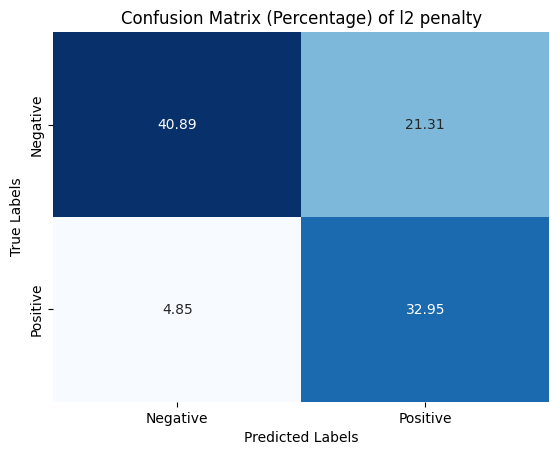

Accuracy: 0.73837687393257
Recall: 0.8717154811715481
confusion matrix: [[12929  6739]
 [ 1533 10417]]
penalty: l2 done
penalty: l1


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


              precision    recall  f1-score   support

           0       0.89      0.66      0.76     19668
           1       0.61      0.87      0.72     11950

    accuracy                           0.74     31618
   macro avg       0.75      0.76      0.74     31618
weighted avg       0.79      0.74      0.74     31618



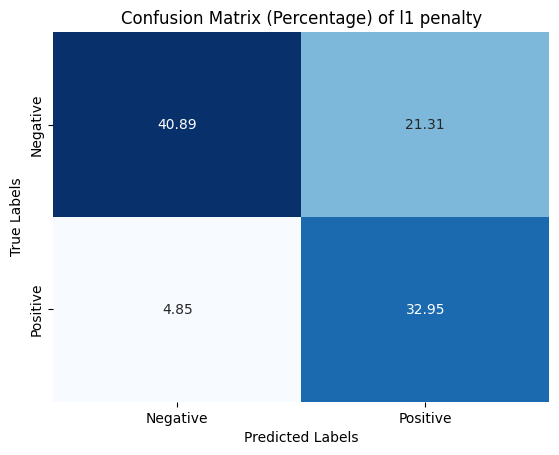

Accuracy: 0.73837687393257
Recall: 0.8717154811715481
confusion matrix: [[12929  6739]
 [ 1533 10417]]
penalty: l1 done
penalty: none


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


              precision    recall  f1-score   support

           0       0.89      0.66      0.76     19668
           1       0.61      0.87      0.72     11950

    accuracy                           0.74     31618
   macro avg       0.75      0.76      0.74     31618
weighted avg       0.79      0.74      0.74     31618



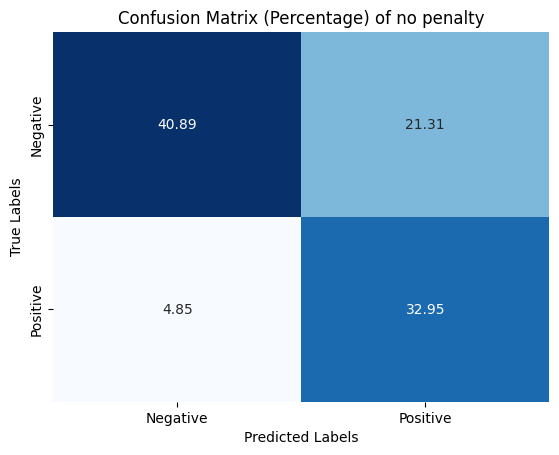

Accuracy: 0.73837687393257
Recall: 0.8717154811715481
confusion matrix: [[12929  6739]
 [ 1533 10417]]
penalty: none done


In [ ]:
c_reach_models = run_logistic_regression_with_penalty(X, y)

In [ ]:
model = k_fold_cv(X, y, 5)

### Random Forest

              precision    recall  f1-score   support

           0       0.90      0.86      0.88     19668
           1       0.78      0.85      0.81     11950

    accuracy                           0.85     31618
   macro avg       0.84      0.85      0.84     31618
weighted avg       0.86      0.85      0.85     31618



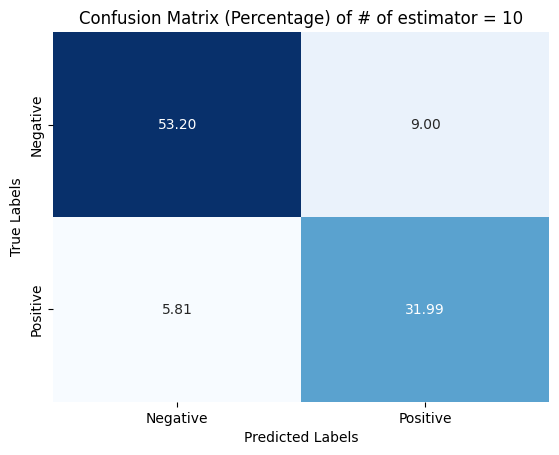

Accuracy: 0.8519197925232462
Recall: 0.8463598326359832
confusion matrix: [[16822  2846]
 [ 1836 10114]]


In [ ]:
run_random_forest(X, y, 10)

In [ ]:
model = k_fold_cv_random_forest(X, y, 5)

### XG Boost

In [ ]:
customer_reach_X_df = customer_reach_final.drop(["trial_completed", 'user_id'], axis=1)
customer_reach_y_df = customer_reach_final[["trial_completed"]]
customer_reach_num_cols = [
    'num_cc', 'trial_money'
]

Accuracy: 87.16%
              precision    recall  f1-score   support

           0       0.93      0.86      0.89     19668
           1       0.79      0.90      0.84     11950

    accuracy                           0.87     31618
   macro avg       0.86      0.88      0.87     31618
weighted avg       0.88      0.87      0.87     31618



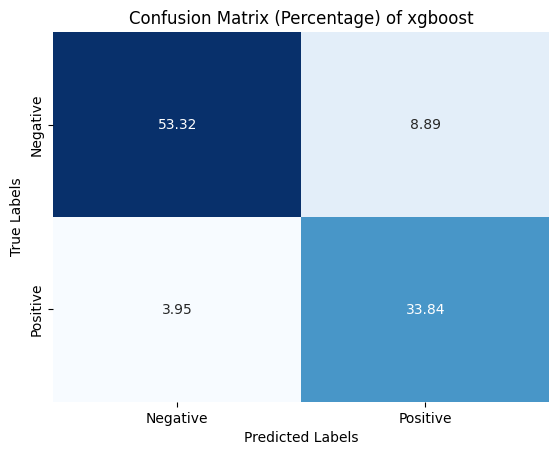

Accuracy: 0.8716237586185085
Recall: 0.8954811715481171
confusion matrix: [[16858  2810]
 [ 1249 10701]]


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    customer_reach_X_df, customer_reach_y_df, test_size=0.2, random_state=42
)

X_train_np = X_train.to_numpy()
y_train_np = y_train.to_numpy()

smote = SMOTE(sampling_strategy='auto', random_state=42)
X_train, y_train = smote.fit_resample(X_train_np, y_train_np)
X_train = pd.DataFrame(X_train, columns=customer_reach_X_df.columns)
y_train = pd.DataFrame(y_train, columns=customer_reach_y_df.columns)

model, dtest = train_xgboost(X_train, y_train, X_test, y_test, num_rounds=300)

predictions = model.predict(dtest)
binary_predictions = [1 if p >= 0.5 else 0 for p in predictions]

# Calculate accuracy
accuracy = accuracy_score(y_test, binary_predictions)
print("Accuracy: %.2f%%" % (accuracy * 100))

plot_confusion_matrix(y_test, binary_predictions, 'xgboost')

In [ ]:
# CV
xgb_model = get_xgb_model()

param_grid = {
    'n_estimators': [50, 100, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
}

grid_search = GridSearchCV(xgb_model, param_grid, cv=3, scoring='f1', verbose=1)
grid_search.fit(X_train, y_train)
best_model = grid_search.best_estimator_
best_pred = best_model.predict(X_test)
plot_confusion_matrix(y_test, best_pred, 'xgboost')

NameError: ignored

In [ ]:
grid_search.best_params_

{'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 300}

In [ ]:

best_model.fit(X_train, y_train)

importance_scores = best_model.feature_importances_

feature_names = X_train.columns

top_10_features = sorted(zip(feature_names, importance_scores), key=lambda x: x[1], reverse=True)[:10]

for feature, _ in top_10_features:
    print(feature)



trial_money
after_policy
channel
study_level
learnt_other
int_fluency
int_speak
int_listen
num_cc
product_want


### Neural Network

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Epoch 1/100: Train Loss: 0.5402, Test Accuracy: 0.8167
Epoch 2/100: Train Loss: 0.5099, Test Accuracy: 0.8303
Epoch 3/100: Train Loss: 0.5043, Test Accuracy: 0.8334
Epoch 4/100: Train Loss: 0.5019, Test Accuracy: 0.8372
Epoch 5/100: Train Loss: 0.5008, Test Accuracy: 0.8323
Epoch 6/100: Train Loss: 0.4993, Test Accuracy: 0.8366
Epoch 7/100: Train Loss: 0.4977, Test Accuracy: 0.8334
Epoch 8/100: Train Loss: 0.4966, Test Accuracy: 0.8374
Epoch 9/100: Train Loss: 0.4965, Test Accuracy: 0.8355
Epoch 10/100: Train Loss: 0.4961, Test Accuracy: 0.8419
Epoch 11/100: Train Loss: 0.4945, Test Accuracy: 0.8350
Epoch 12/100: Train Loss: 0.4943, Test Accuracy: 0.8393
Epoch 13/100: Train Loss: 0.4934, Test Accuracy: 0.8401
Epoch 14/100: Train Loss: 0.4928, Test Accuracy: 0.8416
Epoch 15/100: Train Loss: 0.4929, Test Accuracy: 0.8317
Epoch 16/100: Train Loss: 0.4919, Test Accuracy: 0.8401
Epoch 17/100: Train Loss: 0.4908, Test Accuracy: 0.8367
Epoch 18/100: Train Loss: 0.4908, Test Accuracy: 0.8402
E

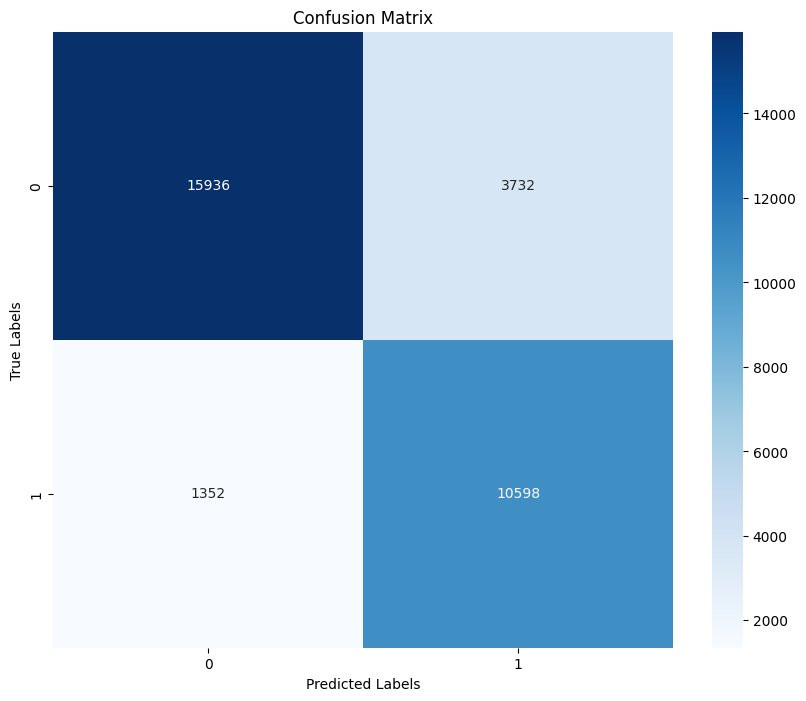

In [ ]:
customer_reach_X_tensor = preprocess_dataframe(customer_reach_X_df, customer_reach_num_cols)
customer_reach_y_tensor = torch.tensor(customer_reach_y_df['trial_completed'])

X_train, y_train, X_test, y_test, y_train_old = get_nn_data(customer_reach_X_tensor, customer_reach_y_tensor)
model = train_nn(X_train, y_train, X_test, y_test, {
    'lr': 0.0002,
    'batch_size': 512,
    'num_epochs': 100
}, [512, 128, 128], device)

Streaming output truncated to the last 5000 lines.
     48        0.4898       0.7907        0.5242  2.0258
     49        0.4893       0.7875        0.5301  1.9014
     50        0.4875       0.7917        0.5223  1.8139
     51        0.4886       0.7941        0.5215  1.9534
     52        0.4889       0.7930        0.5203  1.8187
     53        0.4883       0.7831        0.5327  1.8271
     54        0.4894       0.7991        0.5152  2.0366
     55        0.4879       0.7963        0.5169  1.8130
     56        0.4883       0.7960        0.5181  1.9382
     57        0.4884       0.7935        0.5238  1.8077
     58        0.4890       0.7953        0.5195  1.8240
     59        0.4875       0.8000        0.5144  1.9853
     60        0.4879       0.8002        0.5151  1.9014
     61        0.4867       0.7957        0.5192  1.8591
     62        0.4868       0.7991        0.5235  1.9648
     63        0.4871       0.8002        0.5135  1.8371
     64        0.4872       0.8012   

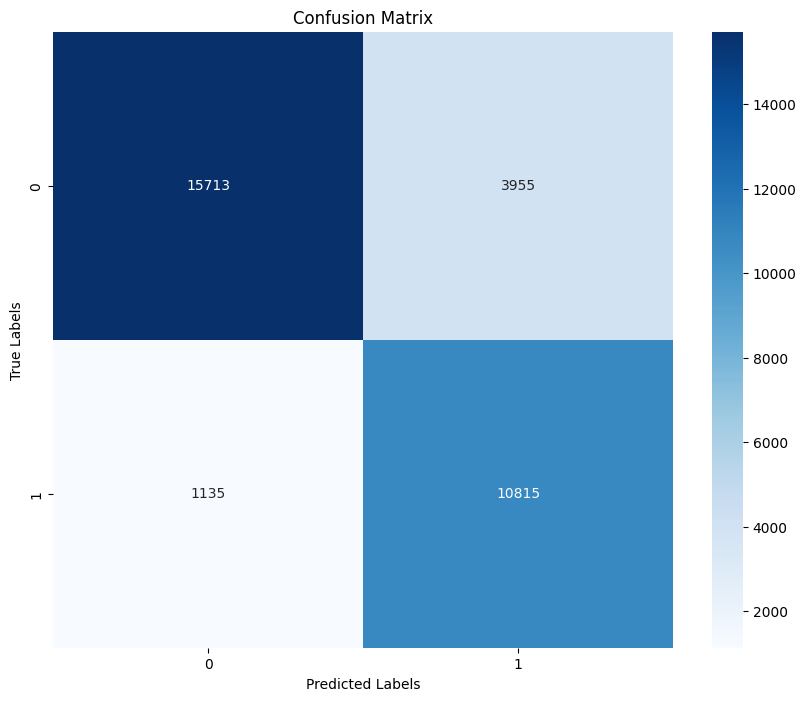

In [ ]:
# CV
network = create_neural_net(X_train.shape[1], [512, 128, 128], y_train.shape[1])
param_grid = {
    'max_epochs': [50, 100, 150],
    'optimizer__lr': [0.0002, 0.001, 0.01],
    'batch_size': [128, 256, 512]
}

gs = GridSearchCV(network, param_grid, cv=3, scoring='f1', verbose=1)
gs.fit(X_train, y_train_old)
best_params = gs.best_params_
best_model = gs.best_estimator_

model = train_nn(X_train, y_train, X_test, y_test, {
    'lr': best_params['optimizer__lr'],
    'batch_size': best_params['batch_size'],
    'num_epochs': best_params['max_epochs']
}, [512, 128, 128], device)

In [ ]:
gs.best_params_

{'batch_size': 512, 'max_epochs': 100, 'optimizer__lr': 0.0002}

# Customer Conversion

### Logistic Regression

In [17]:
y = customer_conversion_final['if_converted']

X = customer_conversion_final.drop(columns=['if_converted', 'user_id'])

penalty: l2


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


              precision    recall  f1-score   support

           0       0.97      0.78      0.87     10200
           1       0.40      0.87      0.55      1716

    accuracy                           0.79     11916
   macro avg       0.69      0.82      0.71     11916
weighted avg       0.89      0.79      0.82     11916



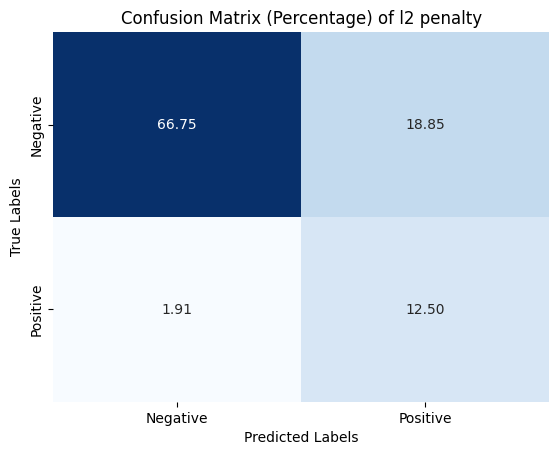

Accuracy: 0.7924639140651225
Recall: 0.8677156177156177
confusion matrix: [[7954 2246]
 [ 227 1489]]
penalty: l2 done
penalty: l1
              precision    recall  f1-score   support

           0       0.97      0.78      0.87     10200
           1       0.40      0.87      0.55      1716

    accuracy                           0.79     11916
   macro avg       0.69      0.82      0.71     11916
weighted avg       0.89      0.79      0.82     11916



/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


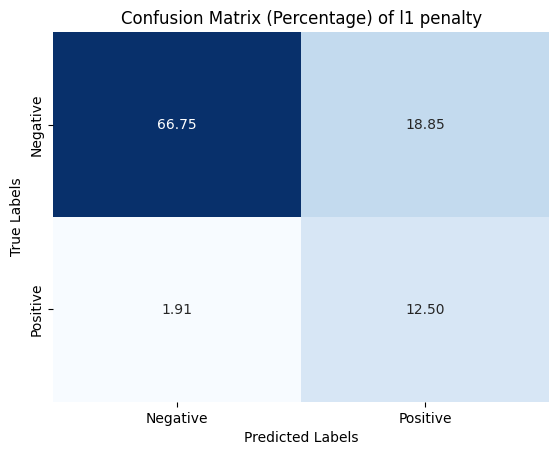

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


Accuracy: 0.7924639140651225
Recall: 0.8677156177156177
confusion matrix: [[7954 2246]
 [ 227 1489]]
penalty: l1 done
penalty: none
              precision    recall  f1-score   support

           0       0.97      0.78      0.87     10200
           1       0.40      0.87      0.55      1716

    accuracy                           0.79     11916
   macro avg       0.69      0.82      0.71     11916
weighted avg       0.89      0.79      0.82     11916



/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


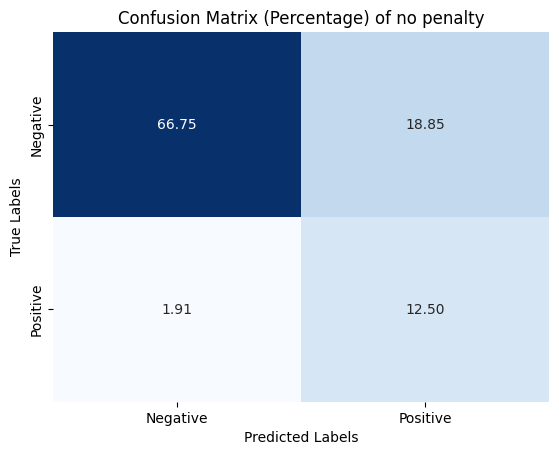

Accuracy: 0.7924639140651225
Recall: 0.8677156177156177
confusion matrix: [[7954 2246]
 [ 227 1489]]
penalty: none done


In [18]:
c_conversion_models = run_logistic_regression_with_penalty(X, y)

In [34]:
model = k_fold_cv(X, y, 5)

### Random Forest

              precision    recall  f1-score   support

           0       0.94      0.95      0.94     10200
           1       0.67      0.62      0.64      1716

    accuracy                           0.90     11916
   macro avg       0.80      0.78      0.79     11916
weighted avg       0.90      0.90      0.90     11916



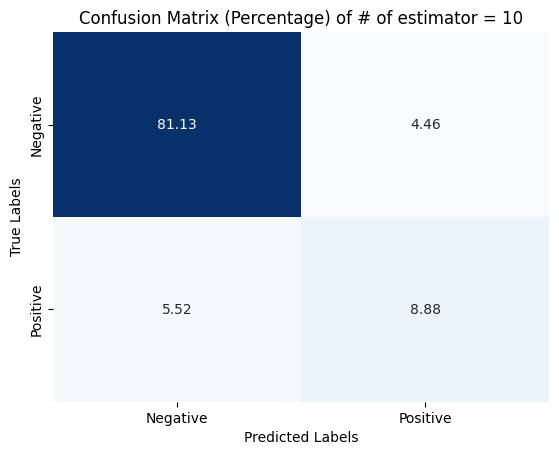

Accuracy: 0.9001342732460558
Recall: 0.6165501165501166
confusion matrix: [[9668  532]
 [ 658 1058]]


In [35]:
run_random_forest(X, y, 10)

In [36]:
model = k_fold_cv_random_forest(X, y, 5)

### XG Boost

In [37]:
customer_conversion_X_df = customer_conversion_final.drop(['user_id', 'if_converted'], axis=1)
customer_conversion_Y_df = customer_conversion_final[['if_converted']]

customer_conversion_X_df['student_evaluation'].replace(np.nan, 0, inplace=True)

customer_conversion_num_cols = [
    't_price', 'num_cc', 'trial_money', 'trial_nums',
    'trial_price', 'num_days_reserve', 'student_evaluation',
    'trial_issue'
]

Accuracy: 92.20%
              precision    recall  f1-score   support

           0       0.95      0.96      0.95     10200
           1       0.74      0.72      0.73      1716

    accuracy                           0.92     11916
   macro avg       0.84      0.84      0.84     11916
weighted avg       0.92      0.92      0.92     11916



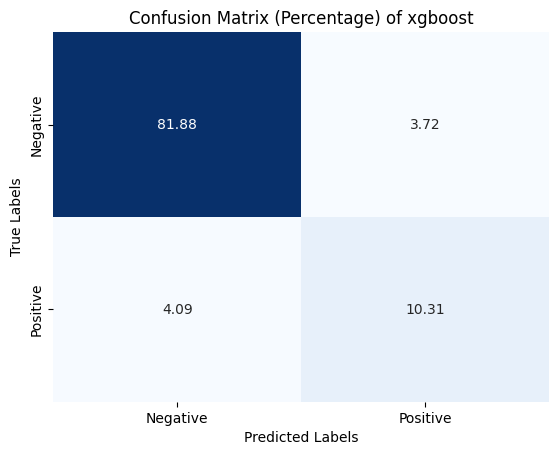

Accuracy: 0.9219536757301108
Recall: 0.7162004662004662
confusion matrix: [[9757  443]
 [ 487 1229]]


In [38]:
X_train, X_test, y_train, y_test = train_test_split(
    customer_conversion_X_df, customer_conversion_Y_df, test_size=0.2, random_state=42
)

X_train_np = X_train.to_numpy()
y_train_np = y_train.to_numpy()

smote = SMOTE(sampling_strategy='auto', random_state=42)
X_train, y_train = smote.fit_resample(X_train_np, y_train_np)
X_train = pd.DataFrame(X_train, columns=customer_conversion_X_df.columns)
y_train = pd.DataFrame(y_train, columns=customer_conversion_Y_df.columns)

model, dtest = train_xgboost(X_train, y_train, X_test, y_test, num_rounds=100)

predictions = model.predict(dtest)
binary_predictions = [1 if p >= 0.5 else 0 for p in predictions]

# Calculate accuracy
accuracy = accuracy_score(y_test, binary_predictions)
print("Accuracy: %.2f%%" % (accuracy * 100))

plot_confusion_matrix(y_test, binary_predictions, 'xgboost')

Fitting 3 folds for each of 27 candidates, totalling 81 fits
              precision    recall  f1-score   support

           0       0.96      0.93      0.94     10200
           1       0.64      0.78      0.71      1716

    accuracy                           0.91     11916
   macro avg       0.80      0.85      0.83     11916
weighted avg       0.92      0.91      0.91     11916



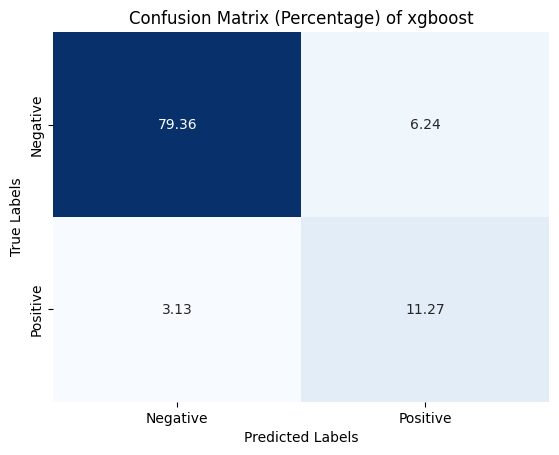

Accuracy: 0.9062604900973481
Recall: 0.7826340326340326
confusion matrix: [[9456  744]
 [ 373 1343]]


In [39]:
# CV
xgb_model = get_xgb_model()

param_grid = {
    'n_estimators': [50, 100, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
}

grid_search = GridSearchCV(xgb_model, param_grid, cv=3, scoring='f1', verbose=1)
grid_search.fit(X_train, y_train)
xg_conversion_best_model = grid_search.best_estimator_
xg_conversion_best_pred = xg_conversion_best_model.predict(X_test)
plot_confusion_matrix(y_test, xg_conversion_best_pred, 'xgboost')

In [40]:
grid_search.best_params_

{'learning_rate': 0.01, 'max_depth': 7, 'n_estimators': 300}

In [41]:
xg_conversion_best_model.fit(X_train, y_train)

importance_scores = xg_conversion_best_model.feature_importances_

feature_names = X_train.columns

top_10_features = sorted(zip(feature_names, importance_scores), key=lambda x: x[1], reverse=True)[:10]

for feature, _ in top_10_features:
    print(feature)



num_cc
int_speak
is_weekend
after_policy
t_patient
cc_id
t_active
channel
purpose
has_comment


### Neural Network

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Epoch 1/100: Train Loss: 0.5496, Test Accuracy: 0.8040
Epoch 2/100: Train Loss: 0.4811, Test Accuracy: 0.8852
Epoch 3/100: Train Loss: 0.4670, Test Accuracy: 0.8754
Epoch 4/100: Train Loss: 0.4600, Test Accuracy: 0.8640
Epoch 5/100: Train Loss: 0.4556, Test Accuracy: 0.8917
Epoch 6/100: Train Loss: 0.4503, Test Accuracy: 0.8776
Epoch 7/100: Train Loss: 0.4483, Test Accuracy: 0.8902
Epoch 8/100: Train Loss: 0.4446, Test Accuracy: 0.8974
Epoch 9/100: Train Loss: 0.4440, Test Accuracy: 0.8651
Epoch 10/100: Train Loss: 0.4410, Test Accuracy: 0.8902
Epoch 11/100: Train Loss: 0.4390, Test Accuracy: 0.8980
Epoch 12/100: Train Loss: 0.4365, Test Accuracy: 0.9018
Epoch 13/100: Train Loss: 0.4360, Test Accuracy: 0.8862
Epoch 14/100: Train Loss: 0.4344, Test Accuracy: 0.9016
Epoch 15/100: Train Loss: 0.4321, Test Accuracy: 0.9031
Epoch 16/100: Train Loss: 0.4322, Test Accuracy: 0.8905
Epoch 17/100: Train Loss: 0.4314, Test Accuracy: 0.8988
Epoch 18/100: Train Loss: 0.4299, Test Accuracy: 0.8960
E

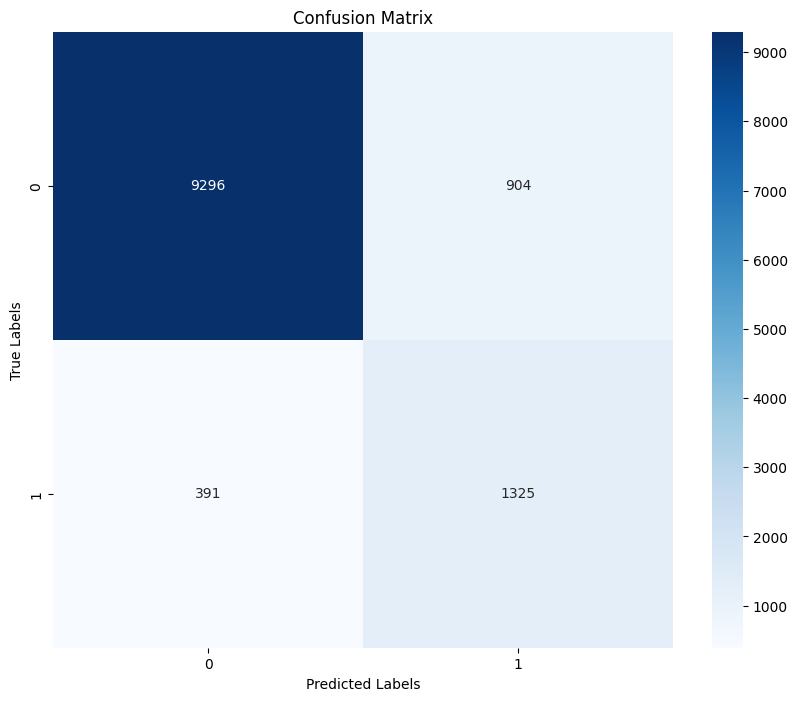

In [42]:
customer_conversion_X_tensor = preprocess_dataframe(customer_conversion_X_df, customer_conversion_num_cols)
customer_conversion_Y_tensor = torch.tensor(customer_conversion_Y_df['if_converted'])

X_train, y_train, X_test, y_test, y_train_old = get_nn_data(customer_conversion_X_tensor, customer_conversion_Y_tensor)
model = train_nn(X_train, y_train, X_test, y_test, {
    'lr': 0.0001,
    'batch_size': 512,
    'num_epochs': 100
}, [2048, 1024, 256, 64], device)

Streaming output truncated to the last 5000 lines.
     46        0.6931       0.5000        0.6931  1.3542
     47        0.6931       0.5000        0.6931  1.3735
     48        0.6931       0.5000        0.6931  1.5096
     49        0.6931       0.5000        0.6931  1.3594
     50        0.6931       0.5000        0.6931  1.3751
     51        0.6931       0.5000        0.6931  1.3389
     52        0.6931       0.5000        0.6931  1.4085
     53        0.6931       0.5000        0.6931  1.3927
     54        0.6931       0.5000        0.6931  1.4745
     55        0.6931       0.5000        0.6931  1.3155
     56        0.6931       0.5000        0.6931  1.3110
     57        0.6931       0.5000        0.6931  1.3078
     58        0.6931       0.5000        0.6931  1.3158
     59        0.6931       0.5000        0.6931  1.4792
     60        0.6931       0.5000        0.6931  1.3350
     61        0.6931       0.5000        0.6931  1.3651
     62        0.6931       0.5000   

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


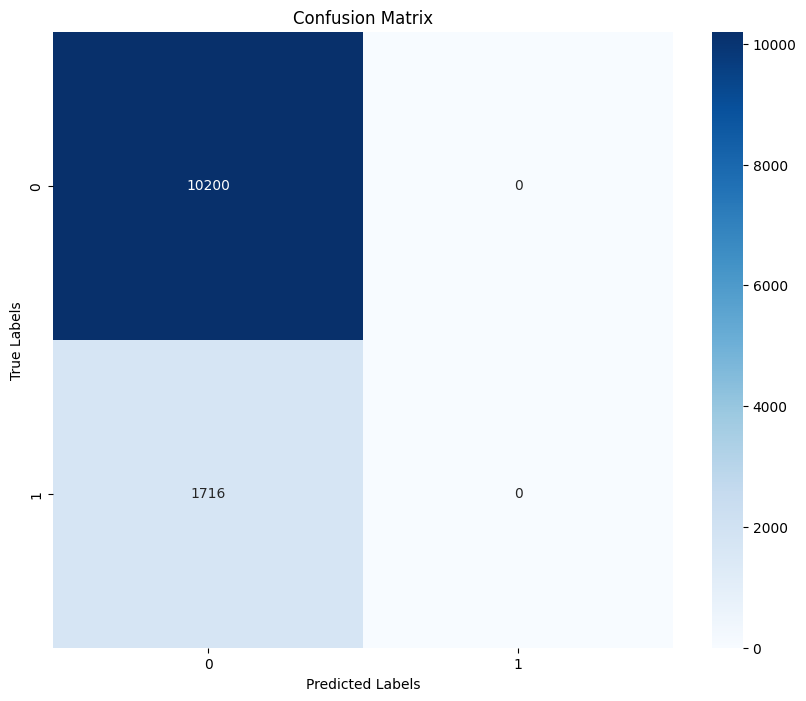

In [43]:
# CV
network = create_neural_net(X_train.shape[1], [2048, 1024, 256, 64], y_train.shape[1])
param_grid = {
    'max_epochs': [50, 100, 150],
    'optimizer__lr': [0.0001, 0.001, 0.01],
    'batch_size': [128, 256, 512]
}

gs = GridSearchCV(network, param_grid, cv=3, scoring='f1', verbose=1)
gs.fit(X_train, y_train_old)
best_params = gs.best_params_
nn_conversion_best_model = gs.best_estimator_

model = train_nn(X_train, y_train, X_test, y_test, {
    'lr': best_params['optimizer__lr'],
    'batch_size': best_params['batch_size'],
    'num_epochs': best_params['max_epochs']
}, [2048, 1024, 256, 64], device)

In [44]:
gs.best_params_

{'batch_size': 128, 'max_epochs': 150, 'optimizer__lr': 0.01}

# Customer Repurchase

### Logistic Regression

In [45]:
y = customer_repurchase_final['if_repurchase']

X = customer_repurchase_final.drop(columns=['if_repurchase', 'user_id'])

penalty: l2
              precision    recall  f1-score   support

           0       0.79      0.64      0.70      1340
           1       0.42      0.61      0.49       580

    accuracy                           0.63      1920
   macro avg       0.60      0.62      0.60      1920
weighted avg       0.68      0.63      0.64      1920



/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


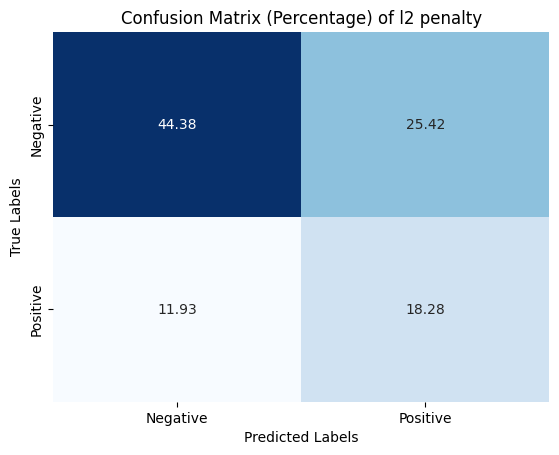

Accuracy: 0.6265625
Recall: 0.6051724137931035
confusion matrix: [[852 488]
 [229 351]]
penalty: l2 done
penalty: l1
              precision    recall  f1-score   support

           0       0.79      0.64      0.70      1340
           1       0.42      0.61      0.49       580

    accuracy                           0.63      1920
   macro avg       0.60      0.62      0.60      1920
weighted avg       0.68      0.63      0.64      1920



/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


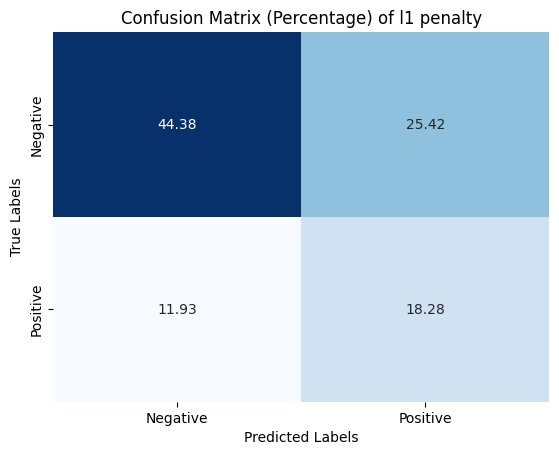

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


Accuracy: 0.6265625
Recall: 0.6051724137931035
confusion matrix: [[852 488]
 [229 351]]
penalty: l1 done
penalty: none


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


              precision    recall  f1-score   support

           0       0.79      0.64      0.70      1340
           1       0.42      0.61      0.49       580

    accuracy                           0.63      1920
   macro avg       0.60      0.62      0.60      1920
weighted avg       0.68      0.63      0.64      1920



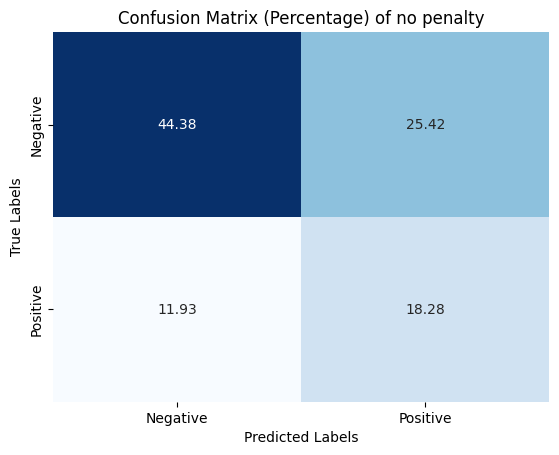

Accuracy: 0.6265625
Recall: 0.6051724137931035
confusion matrix: [[852 488]
 [229 351]]
penalty: none done


In [46]:
c_repurchase_models = run_logistic_regression_with_penalty(X, y)

In [48]:
model = k_fold_cv(X, y, 5)

### Random Forest

              precision    recall  f1-score   support

           0       0.75      0.87      0.80      1340
           1       0.51      0.32      0.40       580

    accuracy                           0.70      1920
   macro avg       0.63      0.59      0.60      1920
weighted avg       0.68      0.70      0.68      1920



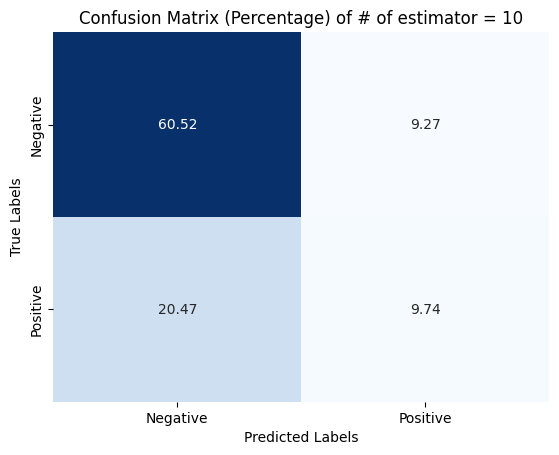

Accuracy: 0.7026041666666667
Recall: 0.32241379310344825
confusion matrix: [[1162  178]
 [ 393  187]]


In [49]:
run_random_forest(X, y, 10)

In [50]:
model = k_fold_cv_random_forest(X, y, 5)

### XG Boost

In [51]:
customer_repurchase_X_df = customer_repurchase_final.drop(['user_id', 'if_repurchase'], axis=1)
customer_repurchase_Y_df = customer_repurchase_final[['if_repurchase']]

customer_repurchase_num_cols = [
    'lesson', 'unitprice', 'productmoney', 'num_cancel',
    'num_completed', 'num_student_absent', 'num_teacher_absent', 'per_cancel',
    'per_completed', 'per_student_absent', 'per_teacher_absent', 'avg_days_class',
    'num_weekday', 'num_weekend', 'num_teacher', 'num_feedback',
    'avg_days_reserve', 't_price'
]

Accuracy: 73.85%
              precision    recall  f1-score   support

           0       0.77      0.90      0.83      1340
           1       0.61      0.37      0.46       580

    accuracy                           0.74      1920
   macro avg       0.69      0.63      0.64      1920
weighted avg       0.72      0.74      0.72      1920



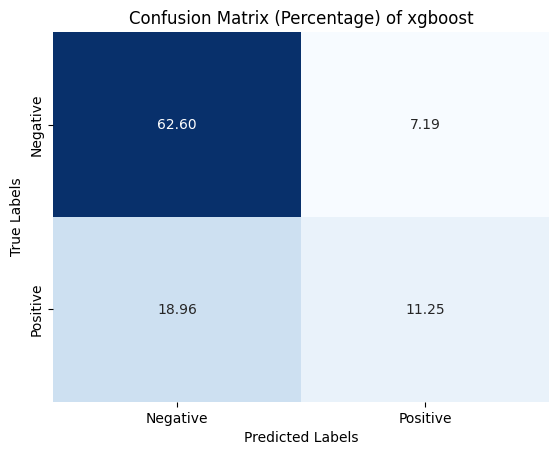

Accuracy: 0.7385416666666667
Recall: 0.3724137931034483
confusion matrix: [[1202  138]
 [ 364  216]]


In [52]:
X_train, X_test, y_train, y_test = train_test_split(
    customer_repurchase_X_df, customer_repurchase_Y_df, test_size=0.2, random_state=42
)

X_train_np = X_train.to_numpy()
y_train_np = y_train.to_numpy()

smote = SMOTE(sampling_strategy='auto', random_state=42)
X_train, y_train = smote.fit_resample(X_train_np, y_train_np)
X_train = pd.DataFrame(X_train, columns=customer_repurchase_X_df.columns)
y_train = pd.DataFrame(y_train, columns=customer_repurchase_Y_df.columns)

model, dtest = train_xgboost(X_train, y_train, X_test, y_test, num_rounds=60)

predictions = model.predict(dtest)
binary_predictions = [1 if p >= 0.5 else 0 for p in predictions]

# Calculate accuracy
accuracy = accuracy_score(y_test, binary_predictions)
print("Accuracy: %.2f%%" % (accuracy * 100))

plot_confusion_matrix(y_test, binary_predictions, 'xgboost')

Fitting 3 folds for each of 27 candidates, totalling 81 fits
              precision    recall  f1-score   support

           0       0.77      0.84      0.80      1340
           1       0.53      0.43      0.47       580

    accuracy                           0.71      1920
   macro avg       0.65      0.63      0.64      1920
weighted avg       0.70      0.71      0.70      1920



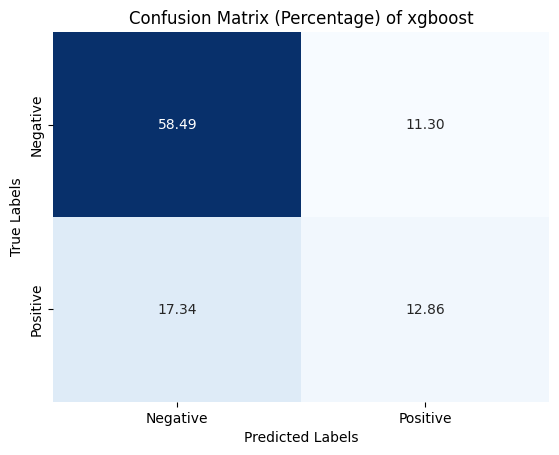

Accuracy: 0.7135416666666666
Recall: 0.42586206896551726
confusion matrix: [[1123  217]
 [ 333  247]]


In [53]:
# CV
xgb_model = get_xgb_model()

param_grid = {
    'n_estimators': [20, 40, 60],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
}

grid_search = GridSearchCV(xgb_model, param_grid, cv=3, scoring='f1', verbose=1)
grid_search.fit(X_train, y_train)
xg_repurchase_best_model = grid_search.best_estimator_
xg_repurchase_best_pred = xg_repurchase_best_model.predict(X_test)
plot_confusion_matrix(y_test, xg_repurchase_best_pred, 'xgboost')

In [54]:
grid_search.best_params_

{'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 60}

In [55]:

xg_repurchase_best_model.fit(X_train, y_train)

importance_scores = xg_repurchase_best_model.feature_importances_

feature_names = X_train.columns

top_10_features = sorted(zip(feature_names, importance_scores), key=lambda x: x[1], reverse=True)[:10]

for feature, _ in top_10_features:
    print(feature)



per_completed
gender
product_want
int_listen
cr_id
job
int_speak
t_humorous
t_experienced
num_cancel


### Neural Networks

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Epoch 1/6: Train Loss: 0.6803, Test Accuracy: 0.6687
Epoch 2/6: Train Loss: 0.6426, Test Accuracy: 0.6979
Epoch 3/6: Train Loss: 0.5968, Test Accuracy: 0.6656
Epoch 4/6: Train Loss: 0.5582, Test Accuracy: 0.6625
Epoch 5/6: Train Loss: 0.5158, Test Accuracy: 0.6969
Epoch 6/6: Train Loss: 0.4856, Test Accuracy: 0.7057
              precision    recall  f1-score   support

           0       0.75      0.87      0.80      1340
           1       0.52      0.33      0.40       580

    accuracy                           0.71      1920
   macro avg       0.64      0.60      0.60      1920
weighted avg       0.68      0.71      0.68      1920

[[1163  177]
 [ 388  192]]


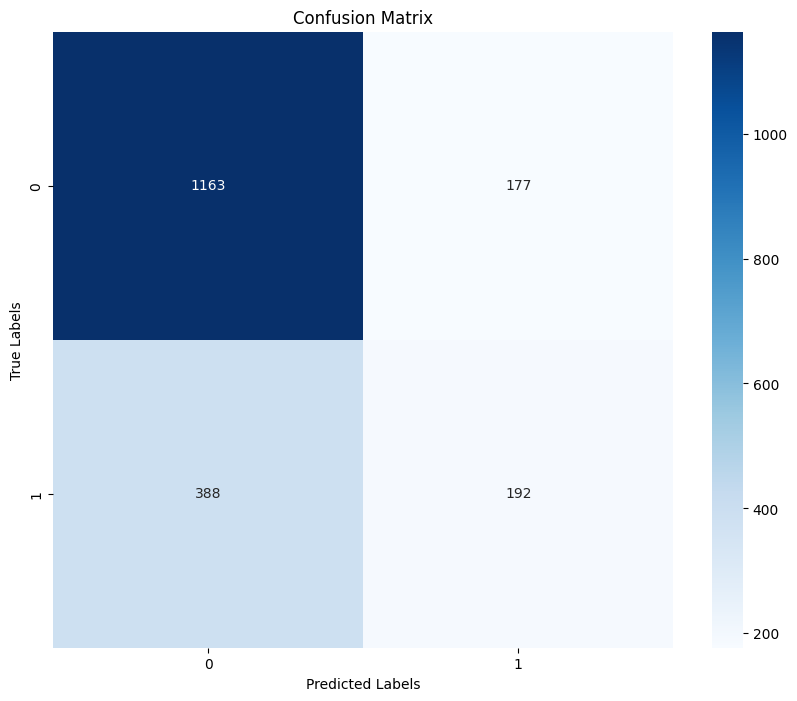

In [56]:
customer_repurchase_X_tensor = preprocess_dataframe(customer_repurchase_X_df, customer_repurchase_num_cols)
customer_repurchase_Y_tensor = torch.tensor(customer_repurchase_Y_df['if_repurchase'])

X_train, y_train, X_test, y_test, y_train_old = get_nn_data(customer_repurchase_X_tensor, customer_repurchase_Y_tensor)
model = train_nn(X_train, y_train, X_test, y_test, {
    'lr': 0.0001,
    'batch_size': 512,
    'num_epochs': 6
}, [1024, 256, 64], device)

Fitting 3 folds for each of 27 candidates, totalling 81 fits
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.7756       0.5003        0.7613  0.5844
      2        0.7665       0.5003        0.7373  0.5878
      3        0.7627       0.5003        0.7352  0.5902
      4        0.7366       0.5003        0.7188  0.5911
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.7008       0.5003        0.6931  0.5945
      2        0.6931       0.5003        0.6931  0.5963
      3        0.6931       0.5003        0.6931  0.5799
      4        0.6931       0.5003        0.6931  0.5936
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.7672       0.5003        0.7276  0.5792
      2        0.7313       0.5003        0.7006  0.5803
      3        0.7172      

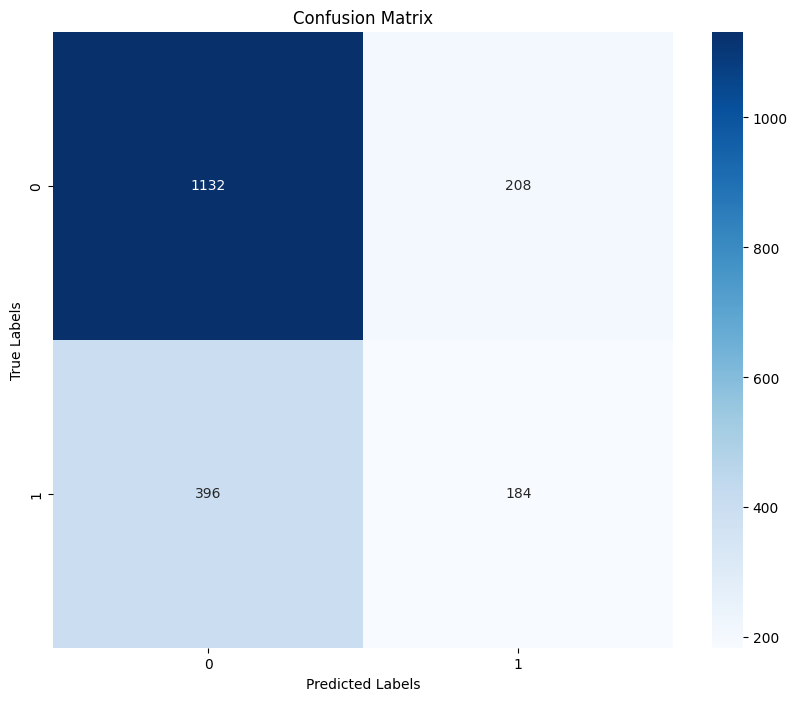

In [57]:
# CV
network = create_neural_net(X_train.shape[1], [1024, 256, 64], y_train.shape[1])
param_grid = {
    'max_epochs': [4, 6, 8],
    'optimizer__lr': [0.0001, 0.001, 0.01],
    'batch_size': [128, 256, 512]
}

gs = GridSearchCV(network, param_grid, cv=3, scoring='f1', verbose=1, error_score='raise')
gs.fit(X_train, y_train_old)
best_params = gs.best_params_
nn_repurchase_best_model = gs.best_estimator_

model = train_nn(X_train, y_train, X_test, y_test, {
    'lr': best_params['optimizer__lr'],
    'batch_size': best_params['batch_size'],
    'num_epochs': best_params['max_epochs']
}, [1024, 256, 64], device)

In [58]:
gs.best_params_

{'batch_size': 128, 'max_epochs': 4, 'optimizer__lr': 0.0001}

# Models Without SMOTE


### Neural Network Definition

In [20]:
class NeuralNetwork(nn.Module):
    def __init__(self, input_dim, hidden_layer_widths, output_dim):
        super(NeuralNetwork, self).__init__()

        layers = []
        layers.append(nn.Linear(input_dim, hidden_layer_widths[0]))
        layers.append(nn.ReLU())
        layers.append(nn.Dropout(0.2))

        for i in range(1, len(hidden_layer_widths)):
            layers.append(nn.Linear(hidden_layer_widths[i-1], hidden_layer_widths[i]))
            nn.init.xavier_uniform_(layers[-1].weight)
            layers.append(nn.LayerNorm(hidden_layer_widths[i]))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(0.2))

        layers.append(nn.Linear(hidden_layer_widths[-1], output_dim))
        layers.append(nn.ReLU())
        layers.append(nn.Dropout(0.2))
        layers.append(nn.Softmax(dim=1))

        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)


def plot_confusion_matrix_nn(model, test_loader, device):
    model.eval()

    with torch.no_grad():
        true_labels = []
        predicted_labels = []

        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            labels = torch.argmax(labels, dim=1)

            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)

            true_labels.extend(labels.cpu().numpy())
            predicted_labels.extend(predicted.cpu().numpy())

        true_labels = np.array(true_labels)
        predicted_labels = np.array(predicted_labels)

    cm = confusion_matrix(true_labels, predicted_labels)
    print(classification_report(true_labels, predicted_labels))
    print(cm)

    # Plot the confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.show()

def create_neural_net(input_dim, hidden_layer_widths, output_dim):
    return NeuralNetClassifier(
        NeuralNetwork,
        max_epochs=150,
        criterion=nn.CrossEntropyLoss(),
        optimizer=optim.Adam,
        optimizer__lr=0.0002,
        batch_size=512,
        device='cuda',
        module__input_dim=input_dim,
        module__hidden_layer_widths=hidden_layer_widths,
        module__output_dim=output_dim
    )

def get_nn_data(X_tensor, y_tensor):
    X_train, X_test, y_train, y_test = train_test_split(
        X_tensor, y_tensor, test_size=0.2, random_state=42
    )
    X_train = torch.tensor(X_train)
    y_train_old = torch.tensor(y_train)
    y_train = nn.functional.one_hot(y_train_old, num_classes=y_train.max() + 1)
    y_test = nn.functional.one_hot(y_test, num_classes=y_test.max() + 1)

    return X_train, y_train, X_test, y_test, y_train_old

def train_nn(X_train, y_train, X_test, y_test, params, layers, device):
    # Creating DataLoader objects for train and test sets
    train_dataset = TensorDataset(X_train, y_train)
    train_loader = DataLoader(train_dataset, batch_size=params['batch_size'], shuffle=True)
    test_dataset = TensorDataset(X_test, y_test)
    test_loader = DataLoader(test_dataset, batch_size=params['batch_size'])

    input_size = X_train.shape[1]
    output_size = y_train.shape[1]
    model = NeuralNetwork(input_size, layers, output_size).to(device)

    # Define the loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=params['lr'])

    # Training loop
    for epoch in range(params['num_epochs']):
        model.train()
        train_loss = 0.0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, torch.argmax(labels, dim=1))
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * inputs.size(0)

        train_loss /= len(train_loader.dataset)

        model.eval()
        correct = 0
        total = 0

        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = model(inputs)
                _, predicted = torch.max(outputs, dim=1)
                total += labels.size(0)
                correct += (predicted == torch.argmax(labels, dim=1)).sum().item()

        test_accuracy = correct / total

        print(f"Epoch {epoch+1}/{params['num_epochs']}: Train Loss: {train_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

    plot_confusion_matrix_nn(model, test_loader, device)

    return model

# Customer Conversion

### XG Boost

In [25]:
customer_conversion_X_df = customer_conversion_final.drop(['user_id', 'if_converted'], axis=1)
customer_conversion_Y_df = customer_conversion_final[['if_converted']]

customer_conversion_X_df['student_evaluation'].replace(np.nan, 0, inplace=True)

customer_conversion_num_cols = [
    't_price', 'num_cc', 'trial_money', 'trial_nums',
    'trial_price', 'num_days_reserve', 'student_evaluation',
    'trial_issue'
]

Accuracy: 92.41%
              precision    recall  f1-score   support

           0       0.95      0.96      0.96     10200
           1       0.75      0.70      0.73      1716

    accuracy                           0.92     11916
   macro avg       0.85      0.83      0.84     11916
weighted avg       0.92      0.92      0.92     11916



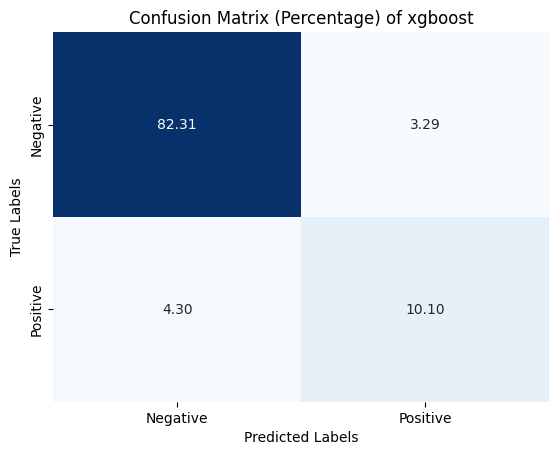

Accuracy: 0.9241356159785162
Recall: 0.7016317016317016
confusion matrix: [[9808  392]
 [ 512 1204]]


In [62]:
X_train, X_test, y_train, y_test = train_test_split(
    customer_conversion_X_df, customer_conversion_Y_df, test_size=0.2, random_state=42
)

model, dtest = train_xgboost(X_train, y_train, X_test, y_test, num_rounds=100)

predictions = model.predict(dtest)
binary_predictions = [1 if p >= 0.5 else 0 for p in predictions]

# Calculate accuracy
accuracy = accuracy_score(y_test, binary_predictions)
print("Accuracy: %.2f%%" % (accuracy * 100))

plot_confusion_matrix(y_test, binary_predictions, 'xgboost')

Fitting 3 folds for each of 27 candidates, totalling 81 fits
              precision    recall  f1-score   support

           0       0.95      0.96      0.96     10200
           1       0.76      0.72      0.74      1716

    accuracy                           0.93     11916
   macro avg       0.86      0.84      0.85     11916
weighted avg       0.93      0.93      0.93     11916



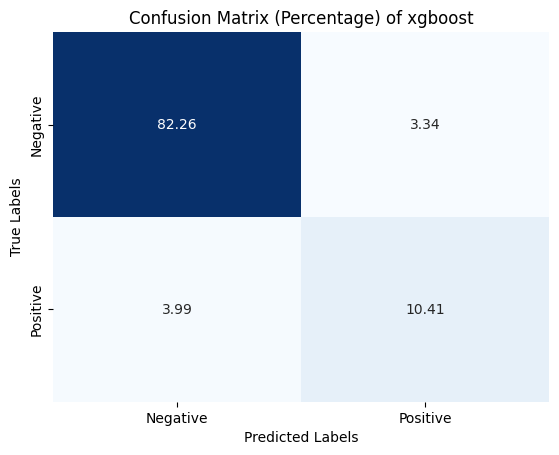

Accuracy: 0.9266532393420611
Recall: 0.7226107226107226
confusion matrix: [[9802  398]
 [ 476 1240]]


In [63]:
# CV
xgb_model = get_xgb_model()

param_grid = {
    'n_estimators': [50, 100, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
}

grid_search = GridSearchCV(xgb_model, param_grid, cv=3, scoring='f1', verbose=1)
grid_search.fit(X_train, y_train)
xg_conversion_nosmote_best_model = grid_search.best_estimator_
xg_conversion_nosmote_best_pred = xg_conversion_nosmote_best_model.predict(X_test)
plot_confusion_matrix(y_test, xg_conversion_nosmote_best_pred, 'xgboost')

In [64]:
grid_search.best_params_

{'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 300}

In [65]:

xg_conversion_nosmote_best_model.fit(X_train, y_train)

importance_scores = xg_conversion_nosmote_best_model.feature_importances_

feature_names = X_train.columns

top_10_features = sorted(zip(feature_names, importance_scores), key=lambda x: x[1], reverse=True)[:10]

for feature, _ in top_10_features:
    print(feature)



num_cc
after_policy
cc_id
has_comment
int_fluency
int_grammar
channel
purpose
trial_money
trial_nums


### Neural Network

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
<ipython-input-20-d93c2c1119f5>:87: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_train = torch.tensor(X_train)
<ipython-input-20-d93c2c1119f5>:88: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train_old = torch.tensor(y_train)


Epoch 1/100: Train Loss: 0.5149, Test Accuracy: 0.8560
Epoch 2/100: Train Loss: 0.5101, Test Accuracy: 0.8560
Epoch 3/100: Train Loss: 0.5086, Test Accuracy: 0.8560
Epoch 4/100: Train Loss: 0.5083, Test Accuracy: 0.8560
Epoch 5/100: Train Loss: 0.5062, Test Accuracy: 0.8560
Epoch 6/100: Train Loss: 0.5075, Test Accuracy: 0.8560
Epoch 7/100: Train Loss: 0.5063, Test Accuracy: 0.8560
Epoch 8/100: Train Loss: 0.5051, Test Accuracy: 0.8560
Epoch 9/100: Train Loss: 0.5061, Test Accuracy: 0.8560
Epoch 10/100: Train Loss: 0.5066, Test Accuracy: 0.8560
Epoch 11/100: Train Loss: 0.5065, Test Accuracy: 0.8560
Epoch 12/100: Train Loss: 0.5047, Test Accuracy: 0.8560
Epoch 13/100: Train Loss: 0.5043, Test Accuracy: 0.8560
Epoch 14/100: Train Loss: 0.5051, Test Accuracy: 0.8560
Epoch 15/100: Train Loss: 0.5048, Test Accuracy: 0.8560
Epoch 16/100: Train Loss: 0.5055, Test Accuracy: 0.8560
Epoch 17/100: Train Loss: 0.5060, Test Accuracy: 0.8560
Epoch 18/100: Train Loss: 0.5049, Test Accuracy: 0.8560
E

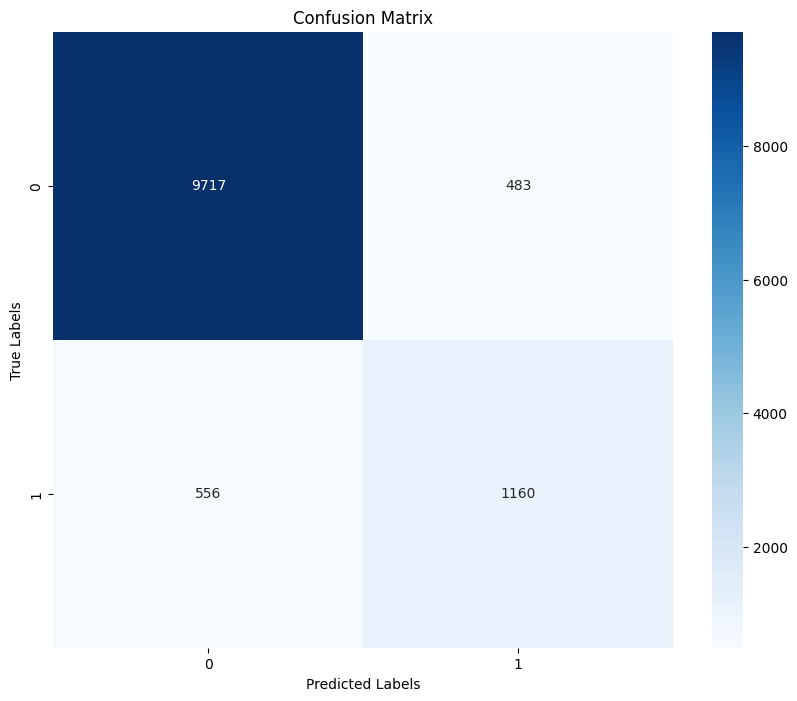

In [26]:
customer_conversion_X_tensor = preprocess_dataframe(customer_conversion_X_df, customer_conversion_num_cols)
customer_conversion_Y_tensor = torch.tensor(customer_conversion_Y_df['if_converted'])

X_train, y_train, X_test, y_test, y_train_old = get_nn_data(customer_conversion_X_tensor, customer_conversion_Y_tensor)
model = train_nn(X_train, y_train, X_test, y_test, {
    'lr': 0.0001,
    'batch_size': 512,
    'num_epochs': 100
}, [2048, 1024, 256, 64], device)

Streaming output truncated to the last 5000 lines.
     50        0.5052       0.8559        0.4576  0.7942
     51        0.5045       0.8559        0.4576  0.7852
     52        0.5041       0.8559        0.4576  0.7775
     53        0.5039       0.8559        0.4576  0.7639
     54        0.5059       0.8559        0.4576  0.7743
     55        0.5064       0.8559        0.4576  0.7820
     56        0.5056       0.8559        0.4576  0.8210
     57        0.5049       0.8559        0.4575  0.9580
     58        0.5051       0.8559        0.4575  0.8145
     59        0.5057       0.8559        0.4575  0.8088
     60        0.5056       0.8559        0.4575  0.7937
     61        0.5062       0.8559        0.4575  0.7722
     62        0.5029       0.8559        0.4575  0.7717
     63        0.5040       0.8559        0.4575  0.7750
     64        0.5031       0.8559        0.4575  0.7737
     65        0.5059       0.8559        0.4575  0.7915
     66        0.4979       0.8559   

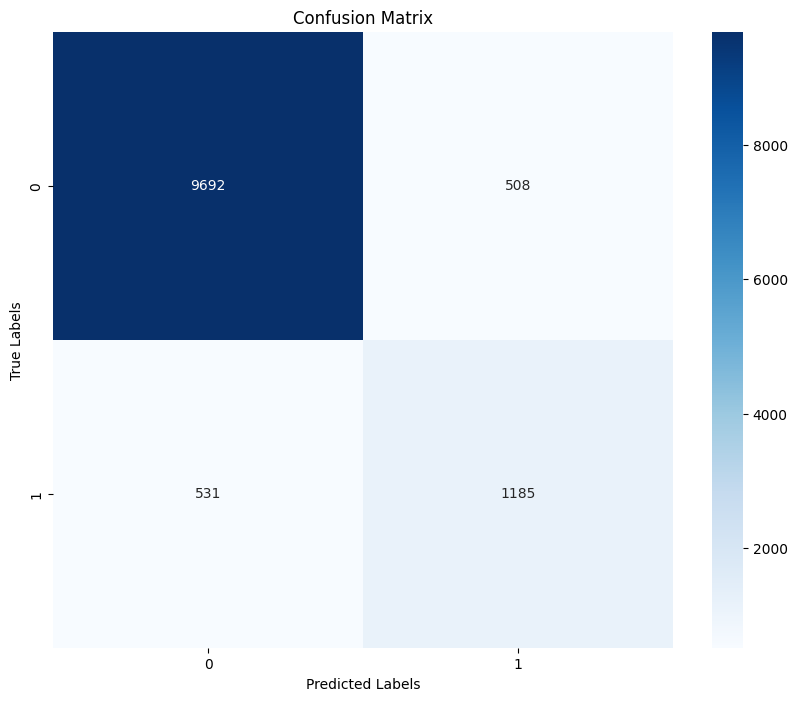

In [27]:
# CV
network = create_neural_net(X_train.shape[1], [2048, 1024, 256, 64], y_train.shape[1])
param_grid = {
    'max_epochs': [50, 100, 150],
    'optimizer__lr': [0.0001, 0.001, 0.01],
    'batch_size': [128, 256, 512]
}

gs = GridSearchCV(network, param_grid, cv=3, scoring='f1', verbose=1)
gs.fit(X_train, y_train_old)
best_params = gs.best_params_
nn_conversion_best_model = gs.best_estimator_

model = train_nn(X_train, y_train, X_test, y_test, {
    'lr': best_params['optimizer__lr'],
    'batch_size': best_params['batch_size'],
    'num_epochs': best_params['max_epochs']
}, [2048, 1024, 256, 64], device)

In [28]:
gs.best_params_

{'batch_size': 128, 'max_epochs': 50, 'optimizer__lr': 0.0001}

# Customer Repurchase

### XG Boost

In [14]:
customer_repurchase_X_df = customer_repurchase_final.drop(['user_id', 'if_repurchase'], axis=1)
customer_repurchase_Y_df = customer_repurchase_final[['if_repurchase']]

customer_repurchase_num_cols = [
    'lesson', 'unitprice', 'productmoney', 'num_cancel',
    'num_completed', 'num_student_absent', 'num_teacher_absent', 'per_cancel',
    'per_completed', 'per_student_absent', 'per_teacher_absent', 'avg_days_class',
    'num_weekday', 'num_weekend', 'num_teacher', 'num_feedback',
    'avg_days_reserve', 't_price'
]

Accuracy: 74.53%
              precision    recall  f1-score   support

           0       0.77      0.90      0.83      1340
           1       0.63      0.38      0.47       580

    accuracy                           0.75      1920
   macro avg       0.70      0.64      0.65      1920
weighted avg       0.73      0.75      0.72      1920



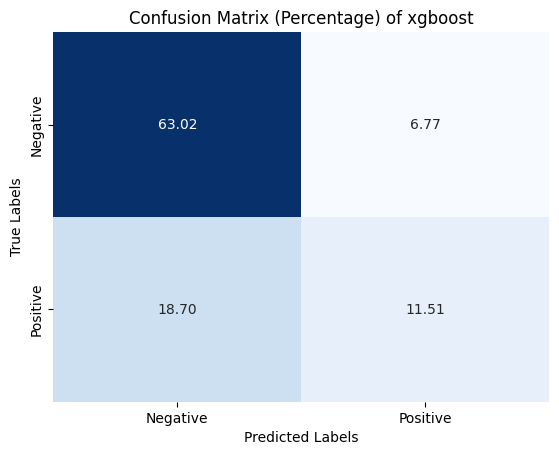

Accuracy: 0.7453125
Recall: 0.3810344827586207
confusion matrix: [[1210  130]
 [ 359  221]]


In [15]:
X_train, X_test, y_train, y_test = train_test_split(
    customer_repurchase_X_df, customer_repurchase_Y_df, test_size=0.2, random_state=42
)


model, dtest = train_xgboost(X_train, y_train, X_test, y_test, num_rounds=60)

predictions = model.predict(dtest)
binary_predictions = [1 if p >= 0.5 else 0 for p in predictions]

# Calculate accuracy
accuracy = accuracy_score(y_test, binary_predictions)
print("Accuracy: %.2f%%" % (accuracy * 100))

plot_confusion_matrix(y_test, binary_predictions, 'xgboost')

Fitting 3 folds for each of 27 candidates, totalling 81 fits
              precision    recall  f1-score   support

           0       0.77      0.92      0.84      1340
           1       0.66      0.37      0.47       580

    accuracy                           0.75      1920
   macro avg       0.71      0.64      0.65      1920
weighted avg       0.74      0.75      0.73      1920



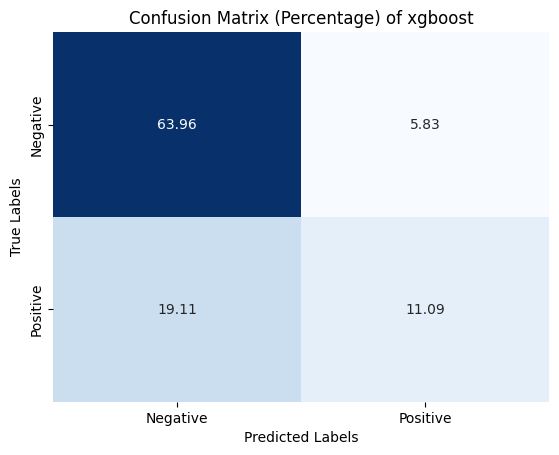

Accuracy: 0.7505208333333333
Recall: 0.36724137931034484
confusion matrix: [[1228  112]
 [ 367  213]]


In [16]:
# CV
xgb_model = get_xgb_model()

param_grid = {
    'n_estimators': [20, 40, 60],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
}

grid_search = GridSearchCV(xgb_model, param_grid, cv=3, scoring='f1', verbose=1)
grid_search.fit(X_train, y_train)
xg_repurchase_nosmote_best_model = grid_search.best_estimator_
xg_repurchase_nosmote_best_pred = xg_repurchase_nosmote_best_model.predict(X_test)
plot_confusion_matrix(y_test, xg_repurchase_nosmote_best_pred, 'xgboost')

In [17]:
grid_search.best_params_

{'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 60}

In [18]:
import xgboost as xgb

xg_repurchase_nosmote_best_model.fit(X_train, y_train)

importance_scores = xg_repurchase_nosmote_best_model.feature_importances_

feature_names = X_train.columns

top_10_features = sorted(zip(feature_names, importance_scores), key=lambda x: x[1], reverse=True)[:10]

for feature, _ in top_10_features:
    print(feature)



product_want
avg_days_class
cr_id
learnt_media
per_completed
num_teacher_absent
age
std_days_between_class
lesson
int_interpret


### Neural Network

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
<ipython-input-20-d93c2c1119f5>:87: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_train = torch.tensor(X_train)
<ipython-input-20-d93c2c1119f5>:88: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train_old = torch.tensor(y_train)


Epoch 1/6: Train Loss: 0.6262, Test Accuracy: 0.6979
Epoch 2/6: Train Loss: 0.6189, Test Accuracy: 0.6979
Epoch 3/6: Train Loss: 0.6104, Test Accuracy: 0.6979
Epoch 4/6: Train Loss: 0.5994, Test Accuracy: 0.6979
Epoch 5/6: Train Loss: 0.5842, Test Accuracy: 0.6979
Epoch 6/6: Train Loss: 0.5764, Test Accuracy: 0.6979
              precision    recall  f1-score   support

           0       0.70      1.00      0.82      1340
           1       0.00      0.00      0.00       580

    accuracy                           0.70      1920
   macro avg       0.35      0.50      0.41      1920
weighted avg       0.49      0.70      0.57      1920

[[1340    0]
 [ 580    0]]


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


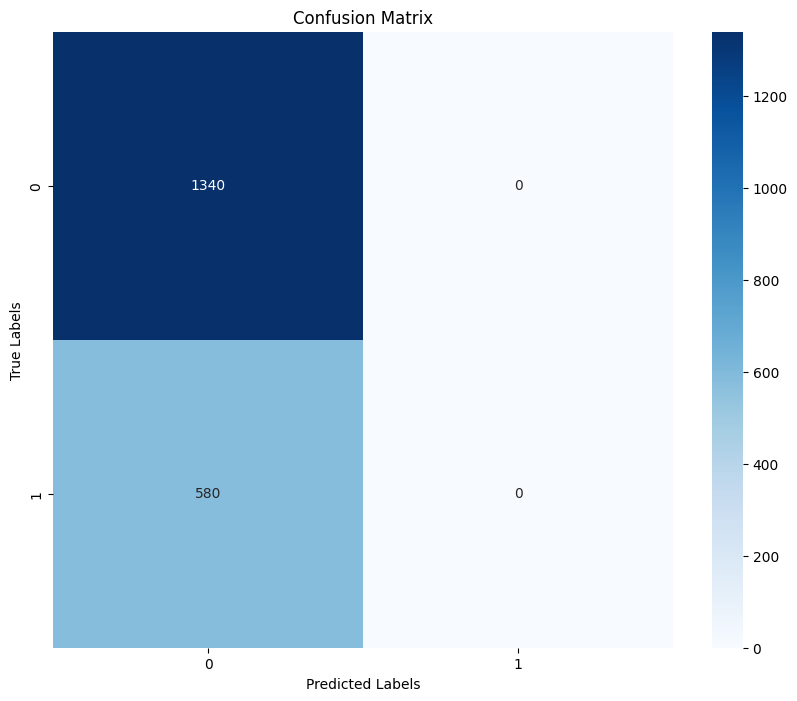

In [21]:
customer_repurchase_X_tensor = preprocess_dataframe(customer_repurchase_X_df, customer_repurchase_num_cols)
customer_repurchase_Y_tensor = torch.tensor(customer_repurchase_Y_df['if_repurchase'])

X_train, y_train, X_test, y_test, y_train_old = get_nn_data(customer_repurchase_X_tensor, customer_repurchase_Y_tensor)
model = train_nn(X_train, y_train, X_test, y_test, {
    'lr': 0.0001,
    'batch_size': 512,
    'num_epochs': 6
}, [1024, 256, 64], device)

Fitting 3 folds for each of 27 candidates, totalling 81 fits
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.6531       0.7109        0.6061  0.4651
      2        0.6239       0.7109        0.6036  0.4409
      3        0.6180       0.7109        0.6016  0.4299
      4        0.6135       0.7109        0.5963  0.4314
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.6222       0.7109        0.6005  0.4433
      2        0.6178       0.7109        0.5856  0.4421
      3        0.5924       0.7373        0.5736  0.4330
      4        0.5710       0.7373        0.5691  0.4340
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.6284       0.7109        0.6022  0.4256
      2        0.6224       0.7109        0.5975  0.4264
      3        0.6085      

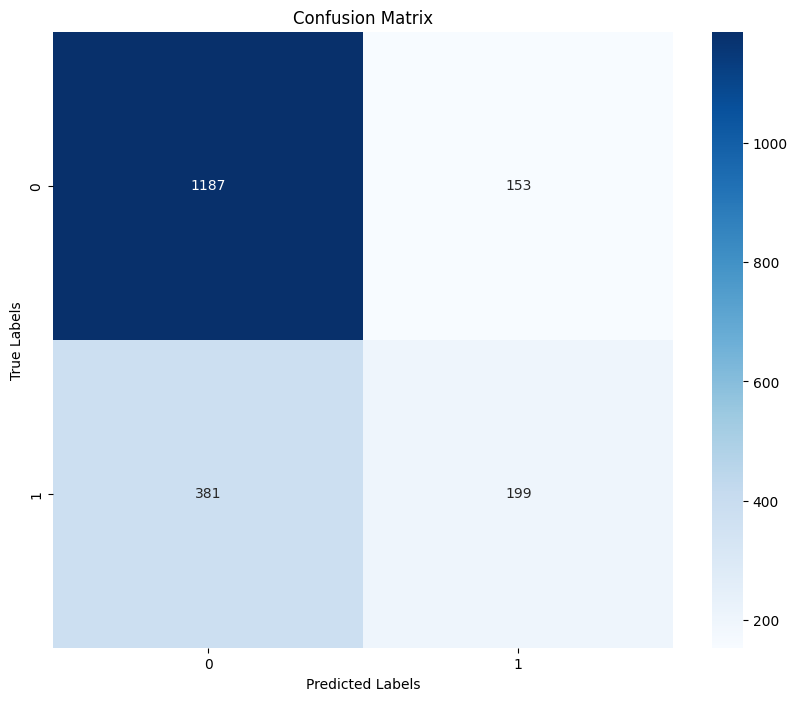

In [22]:
# CV
network = create_neural_net(X_train.shape[1], [1024, 256, 64], y_train.shape[1])
param_grid = {
    'max_epochs': [4, 6, 8],
    'optimizer__lr': [0.0001, 0.001, 0.01],
    'batch_size': [128, 256, 512]
}

gs = GridSearchCV(network, param_grid, cv=3, scoring='f1', verbose=1, error_score='raise')
gs.fit(X_train, y_train_old)
best_params = gs.best_params_
nn_repurchase_best_model = gs.best_estimator_

model = train_nn(X_train, y_train, X_test, y_test, {
    'lr': best_params['optimizer__lr'],
    'batch_size': best_params['batch_size'],
    'num_epochs': best_params['max_epochs']
}, [1024, 256, 64], device)

In [23]:
gs.best_params_

{'batch_size': 128, 'max_epochs': 8, 'optimizer__lr': 0.0001}